# Test 3 & 4: Cholesky CPU

These test capture the runtime for the Cholesky decomposition with GPRat on the GPU.
We use a fixed problem size of $32768=2^{15}$, an increasing number of tiles in $\{1,2,4,8,16,32,64,128,256,512\}$, a number of cores of $48$, 8 regressors, an increasing number of CUDA streams $\{1,2,4,8,16,32,64,128\}$, and loop 11 times (first loop is ignored of warmup).
Note that we do not account for the time it takes to return the data to the callee.

Findings:

- ...

In [2]:
# setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import utils

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams.update({"font.size": 11})
mpl.rcParams.update({"errorbar.capsize": 5})
mpl.rcParams.update({"grid.linewidth": 0.5})

In [3]:
# load data

apex_dir_cholesky = "./data/3"
apex_dir_steps = "./data/4"

names_cholesky = [
    "cholesky"
]

names_steps = [
    "cholesky_step assembly",
    "cholesky_step cholesky",
    "assemble K_tiles",
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
]

file_headers = [
    "n_cores",
    "n_train",
    "n_tiles",
    "n_reg",
    "n_streams",
    "n_loops"
]

def apex_files_to_df(dir, names):
    data = []
    for filename in os.listdir(dir):
        if filename.endswith(".csv"):
            parts = filename.replace("apex_profiles_", "").replace(".csv", "").split("_")
            file_params = dict(zip(file_headers, map(int, parts)))
            file_path = os.path.join(dir, filename)
            df = pd.read_csv(file_path)
            df = df[df['name'].isin(names)]
            for key, value in file_params.items():
                df[key] = value
            data.append(df)
    df_combined = pd.concat(data, ignore_index=True)
    df_combined.sort_values(by="n_tiles", inplace=True)
    return df_combined

df_cholesky = apex_files_to_df(apex_dir_cholesky, names_cholesky)
df_steps = apex_files_to_df(apex_dir_steps, names_steps)

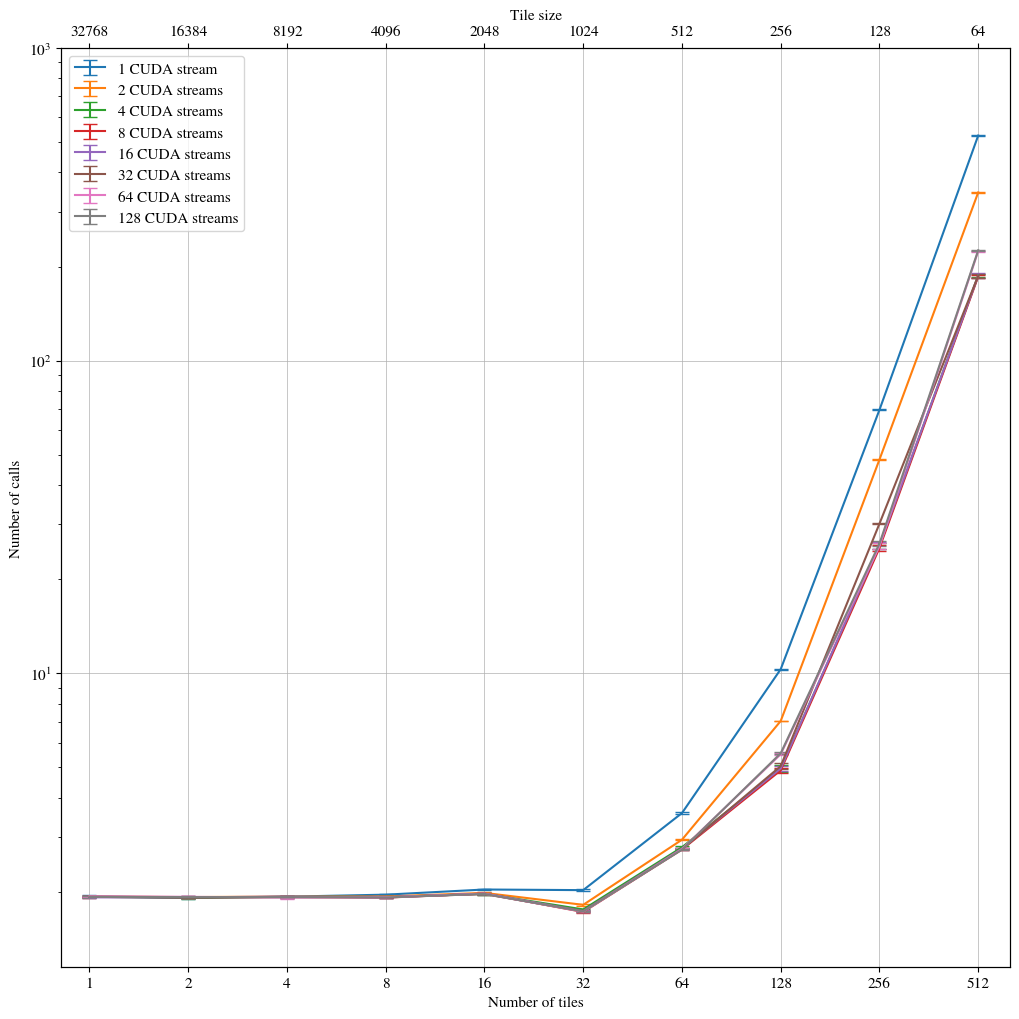

In [5]:
# plot for cholesky

n_train = 32768

fig, ax = plt.subplots(figsize=(10, 10))
ax_top = ax.twiny()

xticks = df_cholesky["n_tiles"].unique()
tile_sizes = n_train / xticks
ax.set_xlim(0.82, 640)
ax.set_ylim(1.15, 1000)
ax.set_xlabel("Number of tiles")
ax.set_ylabel("Number of calls")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(which="both")
ax.grid(False, which="minor")

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

labels = [
    "1 CUDA stream",
    "2 CUDA streams",
    "4 CUDA streams",
    "8 CUDA streams",
    "16 CUDA streams",
    "32 CUDA streams",
    "64 CUDA streams",
    "128 CUDA streams",
]

for (n_streams, group), label in zip(df_cholesky.groupby("n_streams"), labels):
    err = utils.confidence_error(group, 0.95)
    plt.errorbar(
        group["n_tiles"],
        group["mean"] / 10**9,
        yerr=err / 10**9,
        label=label,
    )

plt.legend()
plt.tight_layout(pad=0)
plt.savefig("./pdf/cholesky-gpu.pdf")

/home/moellh/dev/GPRat.git/plot/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_245073/1988859794.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name["acc_stddev"] = np.sqrt(


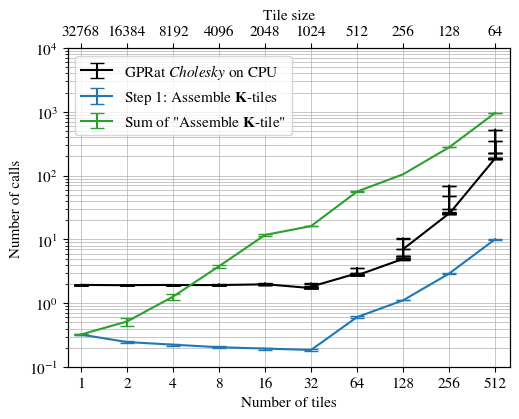

In [18]:
# plot for cholesky: Assembly

n_train = 32768
n_cores = 48

fig, ax = plt.subplots(figsize=(5, 4))
ax_top = ax.twiny()

xticks = df_cholesky["n_tiles"].unique()
tile_sizes = n_train / xticks
ax.set_xlim(0.82, 640)
ax.set_ylim(0.1, 10**4)
ax.set_xlabel("Number of tiles")
ax.set_ylabel("Number of calls")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(True, which="both")

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

df_cholesky_48 = df_cholesky[df_cholesky["n_cores"] == n_cores]
err = utils.confidence_error(df_cholesky_48, 0.95)
plt.errorbar(
    df_cholesky_48["n_tiles"],
    df_cholesky_48["mean"] / 10**9,
    yerr=err / 10**9,
    color="black",
    label=r"GPRat $\it{Cholesky}$ on CPU",
)

df_step_assembly = df_steps[df_steps["name"] == "cholesky_step assembly"]
err = utils.confidence_error(df_step_assembly, 0.95)
plt.errorbar(
    df_step_assembly["n_tiles"],
    df_step_assembly["mean"] / 10**9,
    yerr=err / 10**9,
    label=r"Step 1: Assemble $\mathbf{K}$-tiles",
)


names_blas = [
    "assemble K_tiles",
]
names_steps_legend = [r'Sum of "Assemble $\mathbf{K}$-tile"']

for i, (name, legend_name) in enumerate(zip(names_blas, names_steps_legend)):
    df_name = df_steps[df_steps["name"] == name]
    df_name["acc_stddev"] = np.sqrt(
        df_name["stddev"] ** 2 * df_name["num samples/calls"] / df_name["n_loops"]
    )
    err = utils.confidence_error(df_name, 0.95, "acc_stddev")
    plt.errorbar(
        df_name["n_tiles"],
        df_name["mean"] / 10**9 * df_name["num samples/calls"] / 10,
        yerr=err / 10**9,
        label=r'Sum of "Assemble $\mathbf{K}$-tile"',
        color="tab:green",
    )

plt.legend()
plt.tight_layout(pad=0)
plt.savefig("./pdf/cholesky-gpu-assembly.pdf")

/tmp/ipykernel_26996/1995551234.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name["acc_stddev"] = np.sqrt(
/tmp/ipykernel_26996/1995551234.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name["acc_stddev"] = np.sqrt(
/tmp/ipykernel_26996/1995551234.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

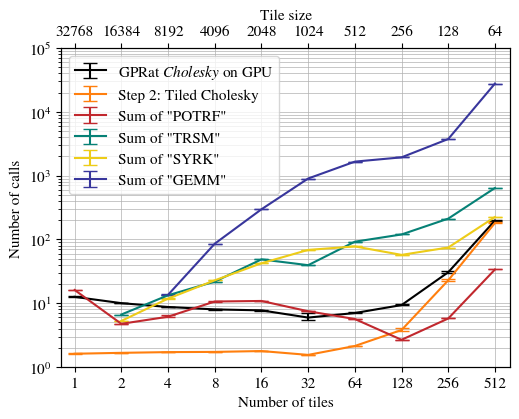

In [39]:
# plot for cholesky BLAS

n_train = 32768
n_cores = 48

fig, ax = plt.subplots(figsize=(5, 4))
ax_top = ax.twiny()

xticks = df_cholesky["n_tiles"].unique()
tile_sizes = n_train / xticks
ax.set_xlim(0.82, 640)
ax.set_ylim(1,10**5)
ax.set_xlabel("Number of tiles")
ax.set_ylabel("Number of calls")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(True, which="both")

ax_top.set_xlim(ax.get_xlim())
ax_top.set_ylim(ax.get_ylim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

df_cholesky_48 = df_cholesky[df_cholesky["n_cores"] == n_cores]
lower, upper = confidence_error(df_cholesky_48, 0.95)
plt.errorbar(
    df_cholesky_48["n_tiles"],
    df_cholesky_48["mean"] / 10**9,
    yerr=[lower / 10**9, upper / 10**9],
    color="black",
    label=r"GPRat $\it{Cholesky}$ on GPU",
)

name = "cholesky_step cholesky"
label = "Step 2: Tiled Cholesky"
df_name = df_steps[df_steps["name"] == name]
lower, upper = confidence_error(df_name, 0.95)
plt.errorbar(
    df_name["n_tiles"],
    df_name["mean"] / 10**9,
    yerr=[lower / 10**9, upper / 10**9],
    label=f"{label}",
    color="tab:orange",
)

names_blas = [
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
]
names_steps_legend = [
    'Sum of "POTRF"',
    'Sum of "TRSM"',
    'Sum of "SYRK"',
    'Sum of "GEMM"',
]
colors = [
    "#c1282e",
    "#068176",
    "#edcc18",
    "#38369c",
]

for name, legend_name, color in zip(names_blas, names_steps_legend, colors):
    df_name = df_steps[df_steps["name"] == name]
    df_name["acc_stddev"] = np.sqrt(
        df_name["stddev"] ** 2 * df_name["num samples/calls"] / df_name["n_loops"]
    )
    lower, upper = confidence_error(df_name, 0.95)
    plt.errorbar(
        df_steps[df_steps["name"] == name]["n_tiles"],
        df_steps[df_steps["name"] == name]["mean"]
        / 10**9
        * df_steps[df_steps["name"] == name]["num samples/calls"],
        yerr=[lower / 10**9, upper / 10**9],
        label=f"{legend_name}",
        color=color,
    )

plt.legend()
plt.tight_layout(pad=0)
plt.savefig("./pdf/cholesky-gpu-blas.pdf")

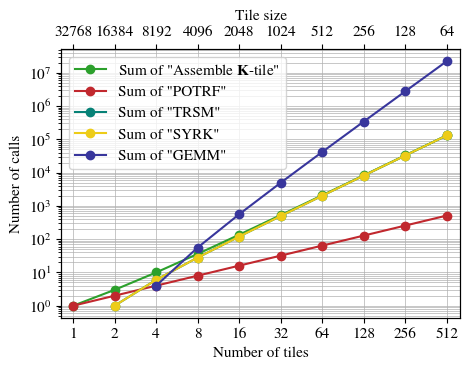

In [31]:
# plot for cholesky num samples/calls

n_train = 32768

fig, ax = plt.subplots(figsize=(4.5, 3.5))
ax_top = ax.twiny()

xticks = df_cholesky["n_tiles"].unique()
tile_sizes = n_train / xticks
ax.set_xlim(0.82, 640)
ax.set_xlabel("Number of tiles")
ax.set_ylabel("Number of calls")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_xticks(xticks, [int(x) for x in xticks])
ax.grid(True, which="both")

ax_top.set_xlim(ax.get_xlim())
ax_top.set_xscale("log", base=2)
ax_top.set_xlabel("Tile size")
ax_top.set_xticks(xticks, [int(tile_size) for tile_size in tile_sizes])

names_blas = [
    "assemble K_tiles",
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
]
names_steps_legend = [
    r'Sum of "Assemble $\mathbf{K}$-tile"',
    'Sum of "POTRF"',
    'Sum of "TRSM"',
    'Sum of "SYRK"',
    'Sum of "GEMM"',
]

colors = [
    "tab:green",
    "#c1282e",
    "#068176",
    "#edcc18",
    "#38369c",
]

for name, legend_name, color in zip(names_blas, names_steps_legend, colors):
    df_name = df_steps[df_steps["name"] == name]
    plt.plot(
        df_name["n_tiles"],
        df_name["num samples/calls"] / df_name["n_loops"],
        label=legend_name,
        color=color,
        marker='o'
    )

plt.legend()
plt.tight_layout(pad=0)
plt.savefig("./pdf/cholesky-numcalls.pdf")